In [1]:
from collections import namedtuple

import jax
import jax.numpy as jnp
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt

from cgc.graph import ComputationalGraph, derivative
from cgc.types import LearnableParameter, ConstantParameter


# Mass-Spring System

## Data Generation

In [2]:
def ms_system_ode(pq, t):
    p, q = pq
    h_grad = [
        -2 * q,
        2 * p
    ]

    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(ms_system_ode, [-0.1, -0.1], t)

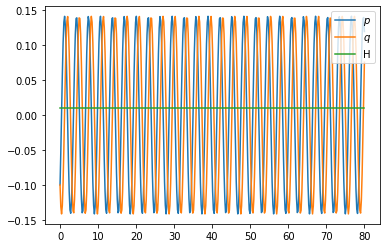

In [3]:
p, q = pq.T
H = 0.5 * (p ** 2 + q ** 2)

plt.plot(t, p, label="$p$")
plt.plot(t, q, label="$q$")
plt.plot(t, H, label="H")
plt.legend()

In [4]:
X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
    #np.full_like(H, fill_value=0.03)[:, np.newaxis]
), axis=1)

M = np.ones_like(X_true).astype(bool)
M[200:, 1:3] = False
M[:, 3] = False

X = np.full_like(X_true, fill_value=0)
X[M] = X_true[M]
X[:, 3] = 0.1

In [5]:
ms_graph = ComputationalGraph(observables_order=["t", "p", "q", "H"])

ms_graph.add_observable("t")
ms_graph.add_unknown_fn("t", "p", alpha=0.01, gamma=LearnableParameter(1.0))
ms_graph.add_unknown_fn("t", "q", alpha=0.01, gamma=LearnableParameter(1.0))

ms_graph.add_known_fn("p", "p_dot", derivative)
ms_graph.add_known_fn("q", "q_dot", derivative)
ms_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

ms_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")

ms_graph.add_aggregator(["p", "q"], "pq")
ms_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, gamma=LearnableParameter(1.0))
ms_graph.add_known_fn("H", "grad_H", derivative)

ms_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
ms_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")

def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, 0], p_dot_grad_H[:, 1:]
    return p_dot + grad_H[:, 1]

def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, 0], q_dot_grad_H[:, 1:]
    return q_dot - grad_H[:, 0]

ms_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
ms_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [6]:
ms_graph.set_loss_multipliers(constraints_loss_multiplier=10000)

In [7]:
Z = ms_graph.complete(X, M, optimizer="l-bfgs-b", learn_parameters=True, n_rounds=20)

  0%|          | 0/10000 [00:00<?, ?it/s]

(CGC Final Round) Loss: 10.6979:   0%|          | 2/10000 [00:17<24:33:03,  8.84s/it]


In [10]:
ms_graph.report_kernel_params()

{'p': 0.7679358720779419, 'q': 0.7693229913711548, 'H': 0.9997020363807678}


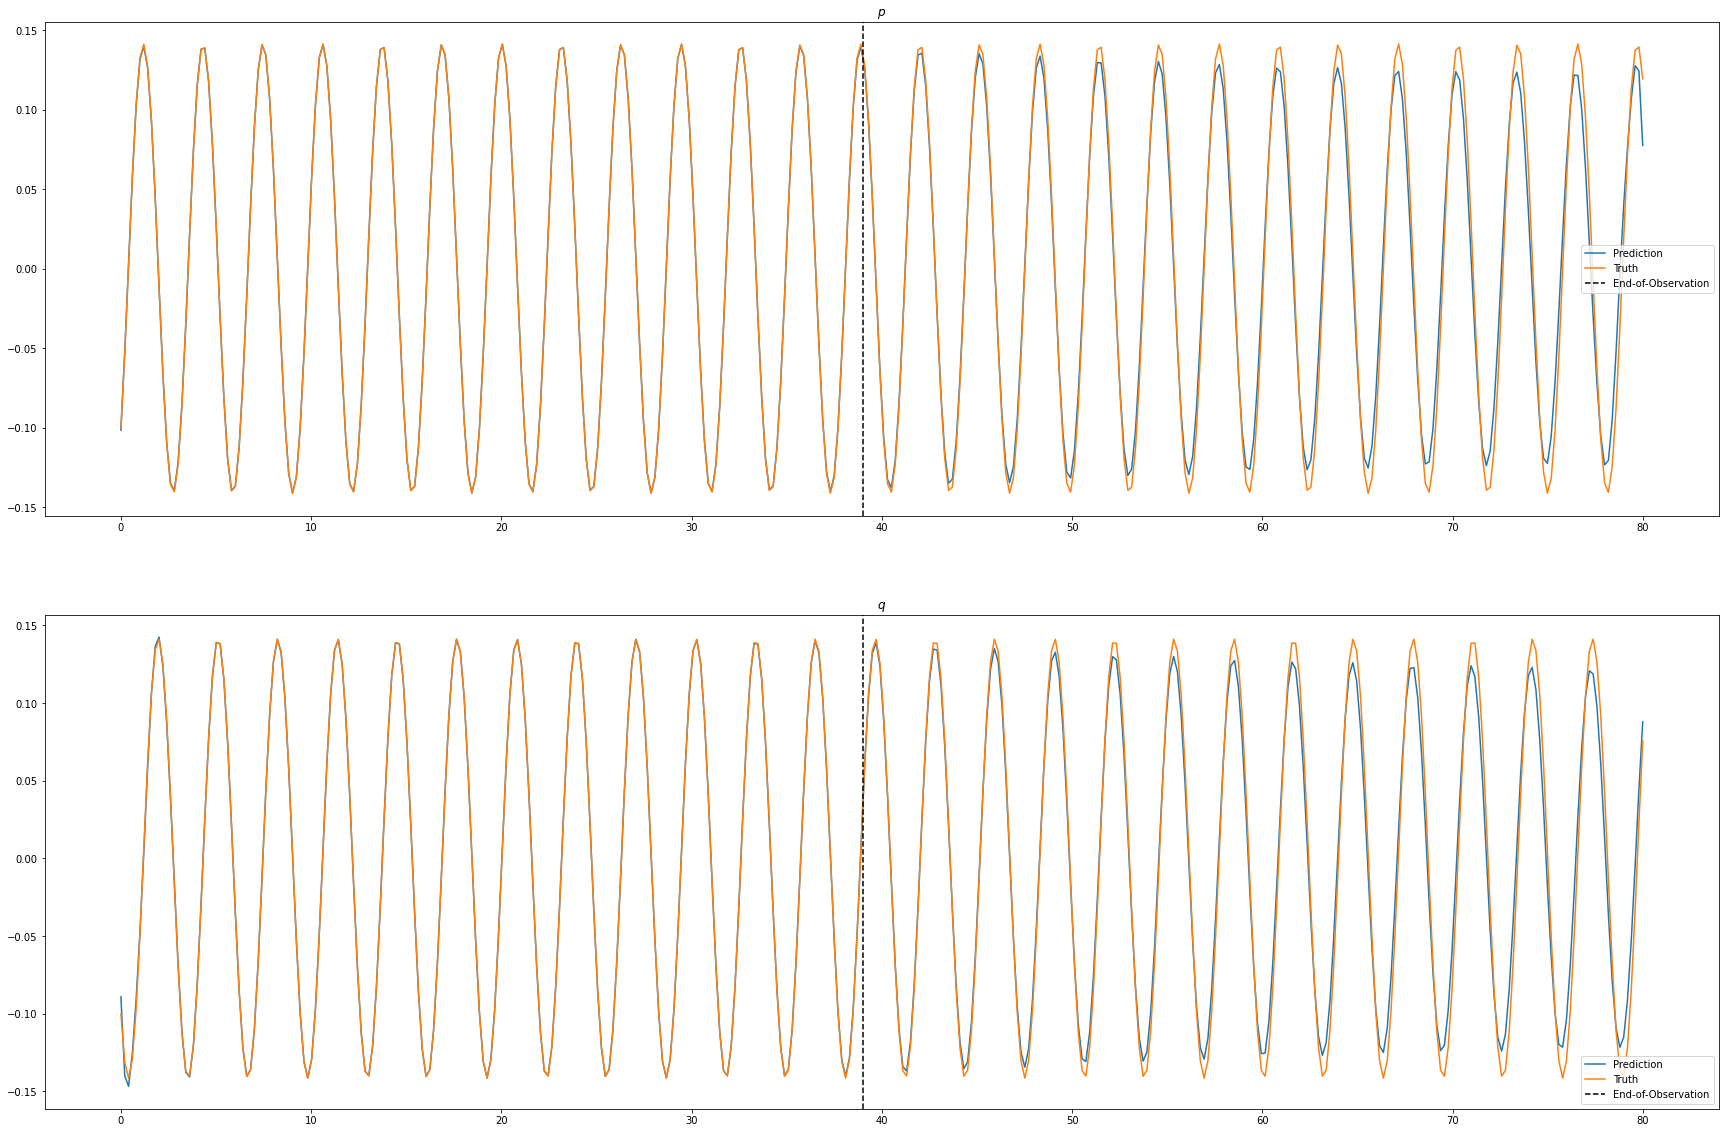

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(30, 20))

axes[0].plot(t, Z[:, 1], label="Prediction")
axes[0].plot(t, p, label="Truth")
axes[0].set_title("$p$")
axes[0].axvline(39, label="End-of-Observation", linestyle="--", c='black')
axes[0].legend()

axes[1].plot(t, Z[:, 2], label="Prediction")
axes[1].plot(t, q, label="Truth")
axes[1].set_title("$q$")
axes[1].axvline(39, label="End-of-Observation", linestyle="--", c='black')
axes[1].legend()

# Two-Mass-Three-Springs System

## Data Generation

In [10]:
def m2s3_system_ode(pq, t):
    p1, p2, q1, q2 = pq
    h_grad = [
        -q1 + (q2 - q1),
        -q2 - (q2 - q1),
        p1,
        p2
    ]
    
    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(m2s3_system_ode, [0.1, -0.1, 0.2, -0.1], t)

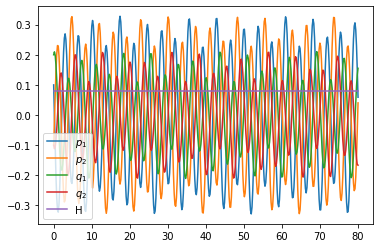

In [11]:
p1, p2, q1, q2 = pq.T
H = 0.5 * (q1 ** 2 + q2 ** 2 + (q2 - q1) ** 2 + p1 ** 2 + p2 ** 2)

plt.plot(t, p1, label="$p_1$")
plt.plot(t, p2, label="$p_2$")
plt.plot(t, q1, label="$q_1$")
plt.plot(t, q2, label="$q_2$")
plt.plot(t, H, label="H")
plt.legend()


In [12]:
X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
), axis=1)

M = np.ones_like(X_true).astype(bool)
M[200:, 1:5] = False
M[:, 5] = False

X = np.zeros_like(X_true)
X[M] = X_true[M]

In [13]:
m2s3_graph = ComputationalGraph(observables_order=["t", "p1", "p2", "q1", "q2", "H"])

m2s3_graph.add_observable("t")
m2s3_graph.add_unknown_fn("t", "p1", alpha=0.01, gamma=LearnableParameter(1.5))
m2s3_graph.add_unknown_fn("t", "p2", alpha=0.01, gamma=LearnableParameter(1.5))
m2s3_graph.add_unknown_fn("t", "q1", alpha=0.01, gamma=LearnableParameter(1.5))
m2s3_graph.add_unknown_fn("t", "q2", alpha=0.01, gamma=LearnableParameter(1.5))

m2s3_graph.add_known_fn("p1", "p1_dot", derivative)
m2s3_graph.add_known_fn("p2", "p2_dot", derivative)
m2s3_graph.add_known_fn("q1", "q1_dot", derivative)
m2s3_graph.add_known_fn("q2", "q2_dot", derivative)

m2s3_graph.add_aggregator(["q1_dot", "q2_dot"], "q_dot")
m2s3_graph.add_aggregator(["p1_dot", "p2_dot"], "p_dot")
m2s3_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

m2s3_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")
m2s3_graph.add_aggregator(["p1", "p2", "q1", "q2"], "pq")

m2s3_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, gamma=1)
m2s3_graph.add_known_fn("H", "grad_H", derivative)

m2s3_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")
def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, :2], p_dot_grad_H[:, 2:]
    return p_dot + grad_H[:, 2:]

m2s3_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, :2], q_dot_grad_H[:, 2:]
    return q_dot - grad_H[:, :2]

m2s3_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
m2s3_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [14]:
m2s3_graph.set_loss_multipliers(constraints_loss_multiplier=10000)

In [15]:
Z = m2s3_graph.complete(X, M, optimizer="l-bfgs-b", learn_parameters=True, n_rounds=20)

(CGC Final Round) Loss: 64.6328:   0%|          | 16/10000 [00:42<7:20:03,  2.64s/it] 


In [16]:
m2s3_graph.report_kernel_params()

{'p1': 0.7925965189933777, 'p2': 0.7876923084259033, 'q1': 0.9662338495254517, 'q2': 0.9727709293365479, 'H': 1.0}


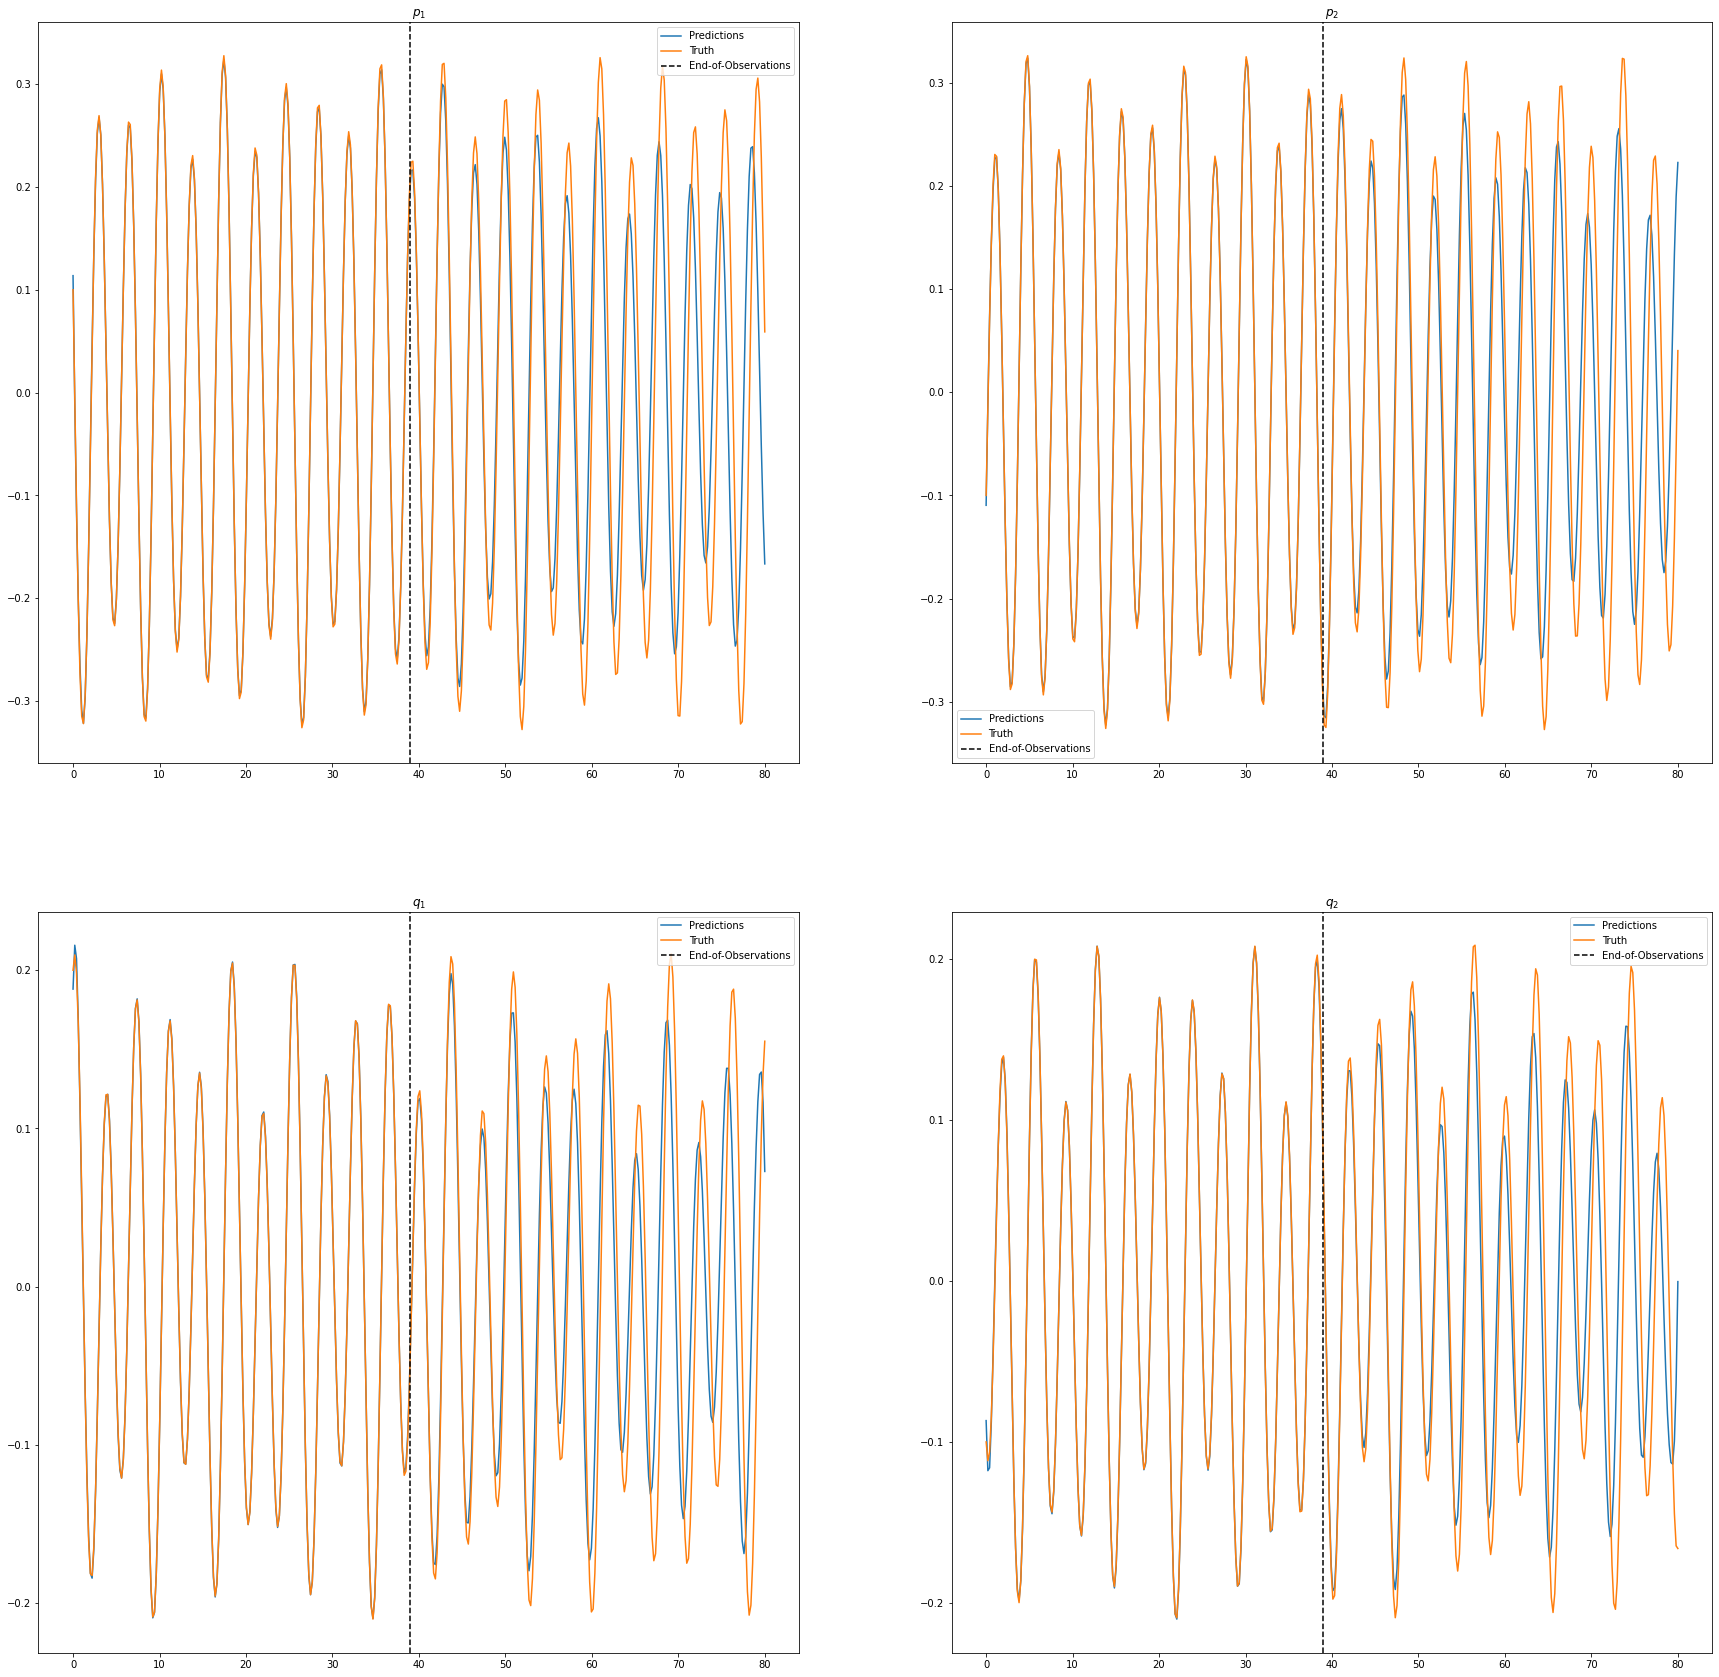

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "index", "truth", "label"])

plots_data = [
    PlotData((0, 0), 1, p1, "$p_1$"),
    PlotData((0, 1), 2, p2, "$p_2$"),
    PlotData((1, 0), 3, q1, "$q_1$"),
    PlotData((1, 1), 4, q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, Z[:, data.index], label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

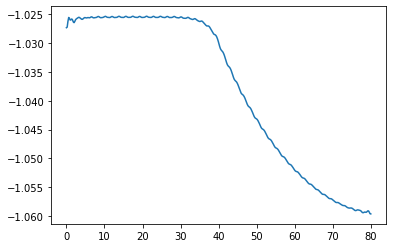

In [18]:
plt.plot(t, Z[:, 5])

# Hénon–Heiles System

## Data Generation

In [11]:
def hh_system_ode(pq, t):
    p1, p2, q1, q2 = pq
    h_grad = [
        -q1 - 2 * q1 * q2,
        -q2 - q1 ** 2 + q2 ** 2,
        p1,
        p2
    ]

    return h_grad

t = np.linspace(0, 80, 400)
pq = odeint(hh_system_ode, [0.1, -0.1, 0.2, -0.1], t)


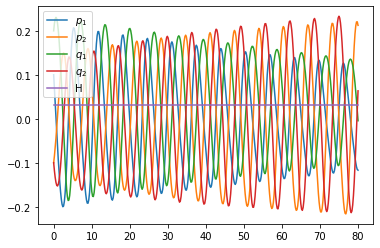

In [12]:
p1, p2, q1, q2 = pq.T
H = 0.5 * (q1 ** 2 + q2 ** 2 + p1 ** 2 + p2 ** 2) + q2 * q1 ** 2 - (1/3) * q2 ** 3

plt.plot(t, p1, label="$p_1$")
plt.plot(t, p2, label="$p_2$")
plt.plot(t, q1, label="$q_1$")
plt.plot(t, q2, label="$q_2$")
plt.plot(t, H, label="H")
plt.legend()


In [13]:
X_true = np.concatenate((
    t[:, np.newaxis],
    pq,
    H[:, np.newaxis],
), axis=1)

M = np.ones_like(X_true).astype(bool)
M[200:, 1:5] = False
M[:, 5] = False

X = np.zeros_like(X_true)
X[M] = X_true[M]

In [14]:
hh_graph = ComputationalGraph(observables_order=["t", "p1", "p2", "q1", "q2", "H"])

hh_graph.add_observable("t")
hh_graph.add_unknown_fn("t", "p1", alpha=0.01, gamma=LearnableParameter(1.2))
hh_graph.add_unknown_fn("t", "p2", alpha=0.01, gamma=LearnableParameter(1.2))
hh_graph.add_unknown_fn("t", "q1", alpha=0.01, gamma=LearnableParameter(1.2))
hh_graph.add_unknown_fn("t", "q2", alpha=0.01, gamma=LearnableParameter(1.2))

hh_graph.add_known_fn("p1", "p1_dot", derivative)
hh_graph.add_known_fn("p2", "p2_dot", derivative)
hh_graph.add_known_fn("q1", "q1_dot", derivative)
hh_graph.add_known_fn("q2", "q2_dot", derivative)

hh_graph.add_aggregator(["q1_dot", "q2_dot"], "q_dot")
hh_graph.add_aggregator(["p1_dot", "p2_dot"], "p_dot")
hh_graph.add_known_fn("p_dot", "-p_dot", lambda p_dot: -p_dot)

hh_graph.add_aggregator(["q_dot", "-p_dot"], "qp_dot")
hh_graph.add_aggregator(["p1", "p2", "q1", "q2"], "pq")

hh_graph.add_unknown_fn("pq", "H", linear_functional=jax.jacobian, observations="qp_dot", alpha=0.01, gamma=1.0)
hh_graph.add_known_fn("H", "grad_H", derivative)

hh_graph.add_aggregator(["p_dot", "grad_H"], "(p_dot, grad_H)")
def p_dot_constraint(p_dot_grad_H):
    p_dot, grad_H = p_dot_grad_H[:, :2], p_dot_grad_H[:, 2:]
    return p_dot + grad_H[:, 2:]

hh_graph.add_aggregator(["q_dot", "grad_H"], "(q_dot, grad_H)")
def q_dot_constraint(q_dot_grad_H):
    q_dot, grad_H = q_dot_grad_H[:, :2], q_dot_grad_H[:, 2:]
    return q_dot - grad_H[:, :2]

hh_graph.add_constraint("(p_dot, grad_H)", "W1", p_dot_constraint)
hh_graph.add_constraint("(q_dot, grad_H)", "W2", q_dot_constraint)

In [15]:
hh_graph.set_loss_multipliers(constraints_loss_multiplier=10000)

In [16]:
Z = hh_graph.complete(X, M, optimizer="l-bfgs-b", learn_parameters=True, n_rounds=20)

(CGC Final Round) Loss: 128.8910:   0%|          | 1/10000 [00:49<136:55:22, 49.30s/it]


In [17]:
hh_graph.report_kernel_params()

{'p1': 1.1233965158462524, 'p2': 1.207086205482483, 'q1': 1.1315070390701294, 'q2': 1.1415269374847412, 'H': 1.0}


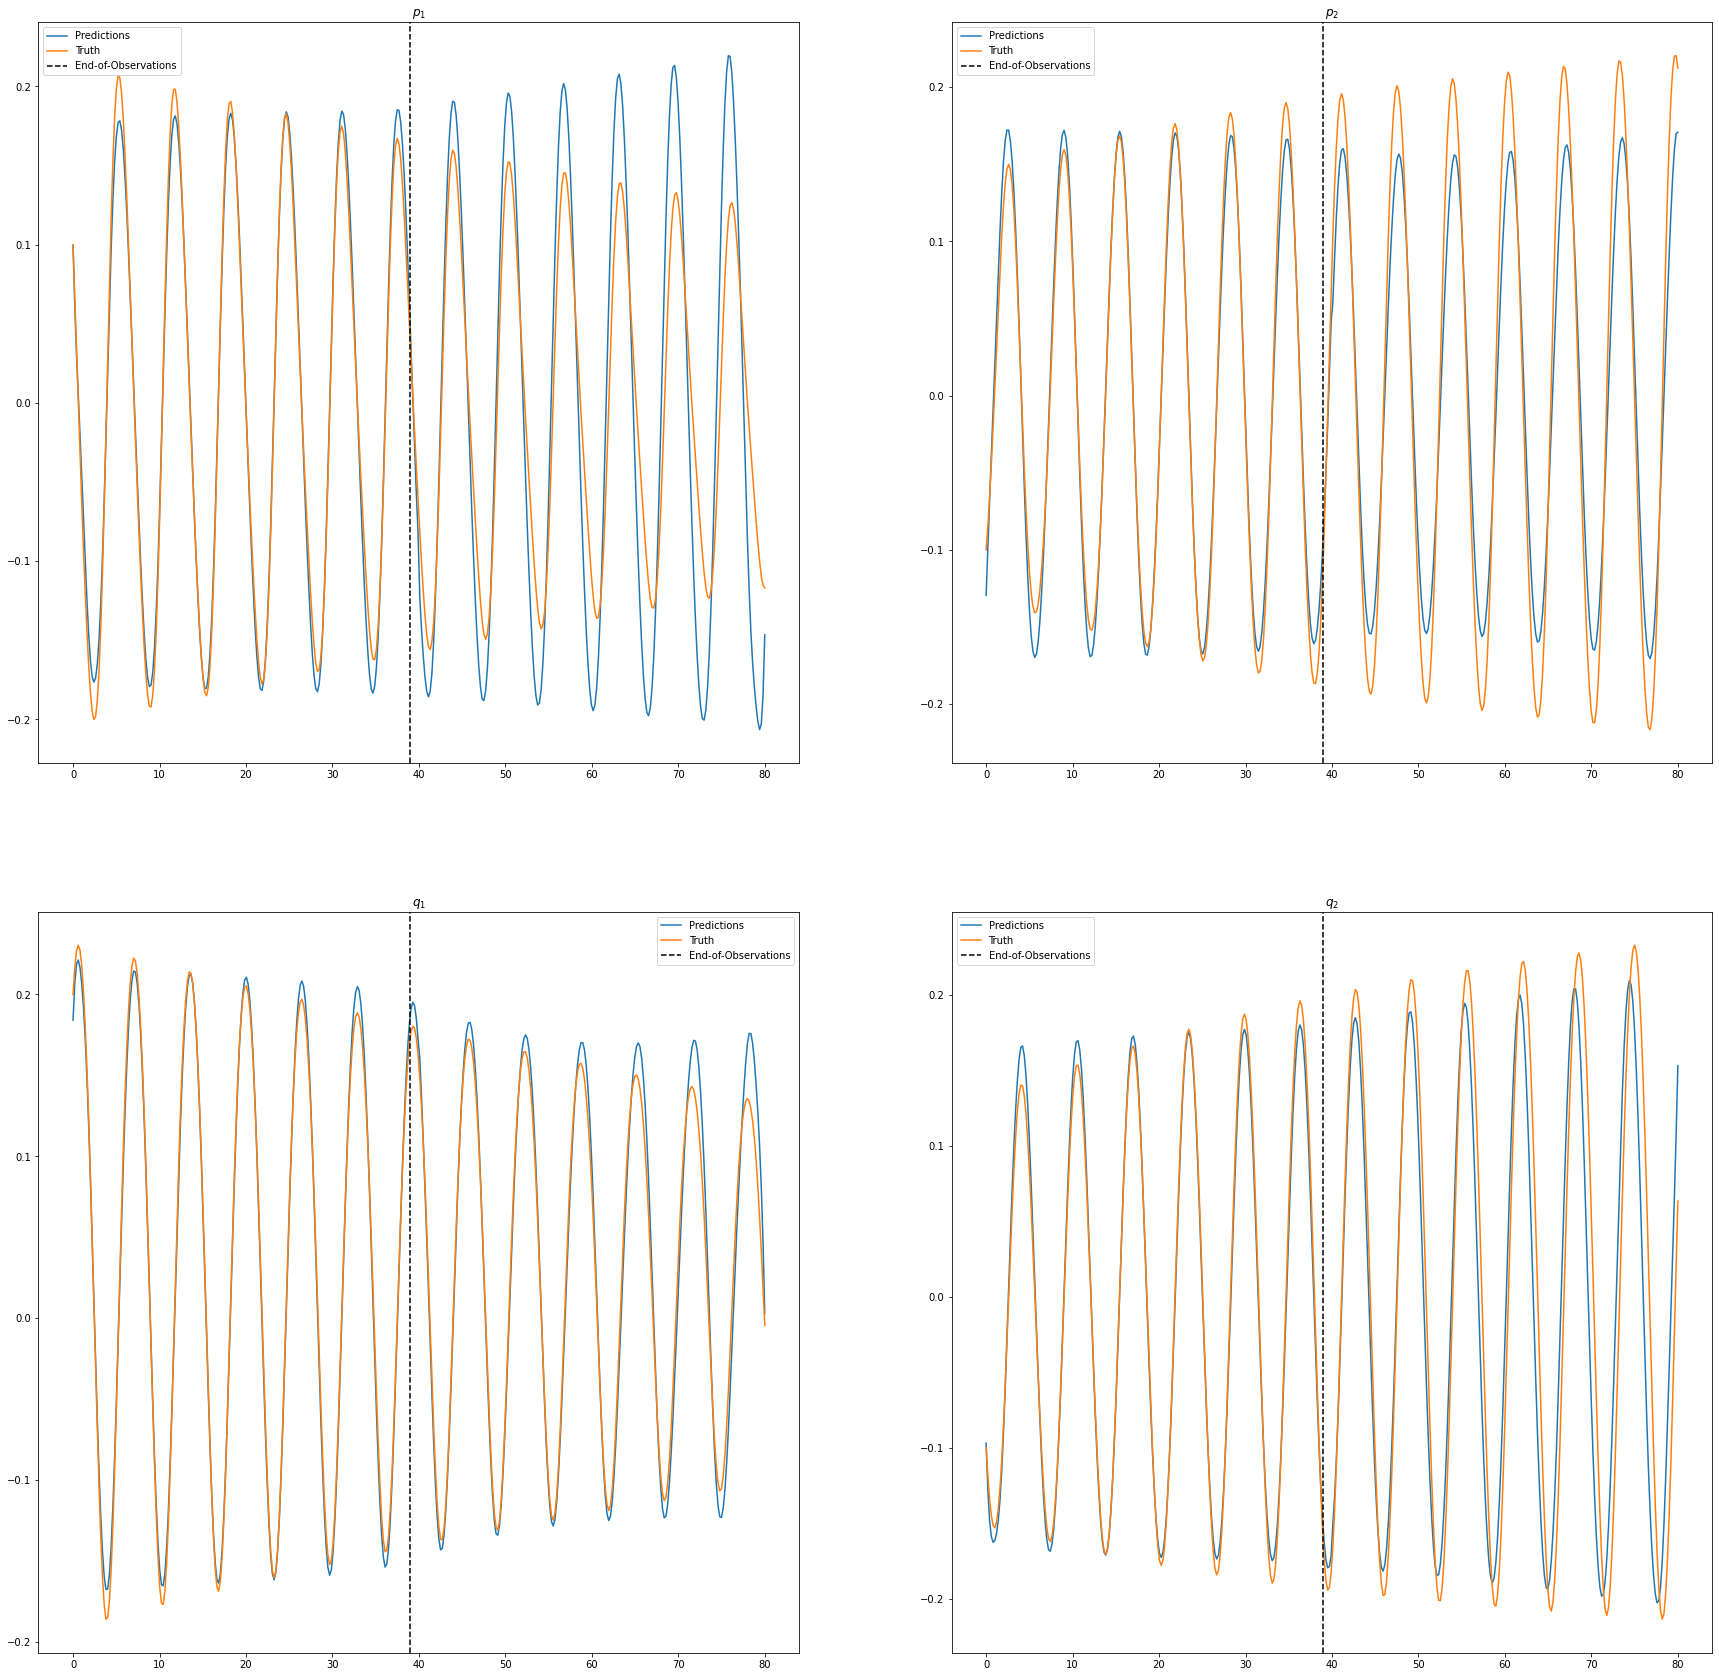

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(30, 30))

PlotData = namedtuple("PlotData", ["axes", "index", "truth", "label"])

plots_data = [
    PlotData((0, 0), 1, p1, "$p_1$"),
    PlotData((0, 1), 2, p2, "$p_2$"),
    PlotData((1, 0), 3, q1, "$q_1$"),
    PlotData((1, 1), 4, q2, "$q_2$")
]

for data in plots_data:
    i,j = data.axes

    axes[i, j].plot(t, Z[:, data.index], label="Predictions")
    axes[i, j].plot(t, data.truth, label="Truth")
    axes[i, j].axvline(39, label="End-of-Observations", linestyle='--', c='black')
    axes[i, j].set_title(data.label)
    axes[i, j].legend()

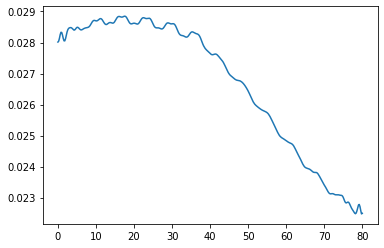

In [10]:
plt.plot(t, Z[:, 5])


# [WIP] Periodically driven pendulum

## Data Generation

In [3]:
import jax
import jax.numpy as jnp
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt

nu = 5
lam = 1

def H(p, q, t):
    return 0.5 * p ** 2 - (nu ** 2) * jnp.cos(q) - lam * (0.3 * p * q * jnp.sin(0.2 * t) + 0.7 * p * q * jnp.sin(0.3 * t))

def dq_H(p, q, t):
    return (nu ** 2) * np.sin(q) - lam * p * (0.3 * np.sin(2 * t) + 0.7 * np.sin(3 * t))

def dp_H(p, q, t):
    return p - lam * q * (0.3 * np.sin(2 * t) + 0.7 * np.sin(3 * t))

#dq_H = jax.vmap(
#        jax.vmap(
#            jax.vmap(jax.grad(H, argnums=1), in_axes=(None, None, 0)),
#            in_axes=(None, 0, None)
#        ),
#        in_axes=(0, None, None)
#)
#dq_H = jax.vmap(jax.grad(H, argnums=1), (0, 0, 0))
#dp_H = jax.vmap(jax.grad(H, argnums=0), (0, 0, 0))

p_dot = lambda p, q, t: -1 * dq_H(p, q, t)
q_dot = lambda p, q, t: dp_H(p, q, t)

def system_ode(pq, t):
    h_grad = [0, 0]
    p, q = pq
    h_grad[0] = p_dot(p, q, t)
    h_grad[1] = q_dot(p, q, t)
    return h_grad

t = np.linspace(0, 40, 400)
pq = odeint(system_ode, [0.1, 0.1], t=t)


In [4]:
h_values = H(pq[:, 0], pq[:, 1], t)
np.mean(h_values)

DeviceArray(-24.863781, dtype=float32)

In [5]:
np.std(h_values)

DeviceArray(0.00356985, dtype=float32)

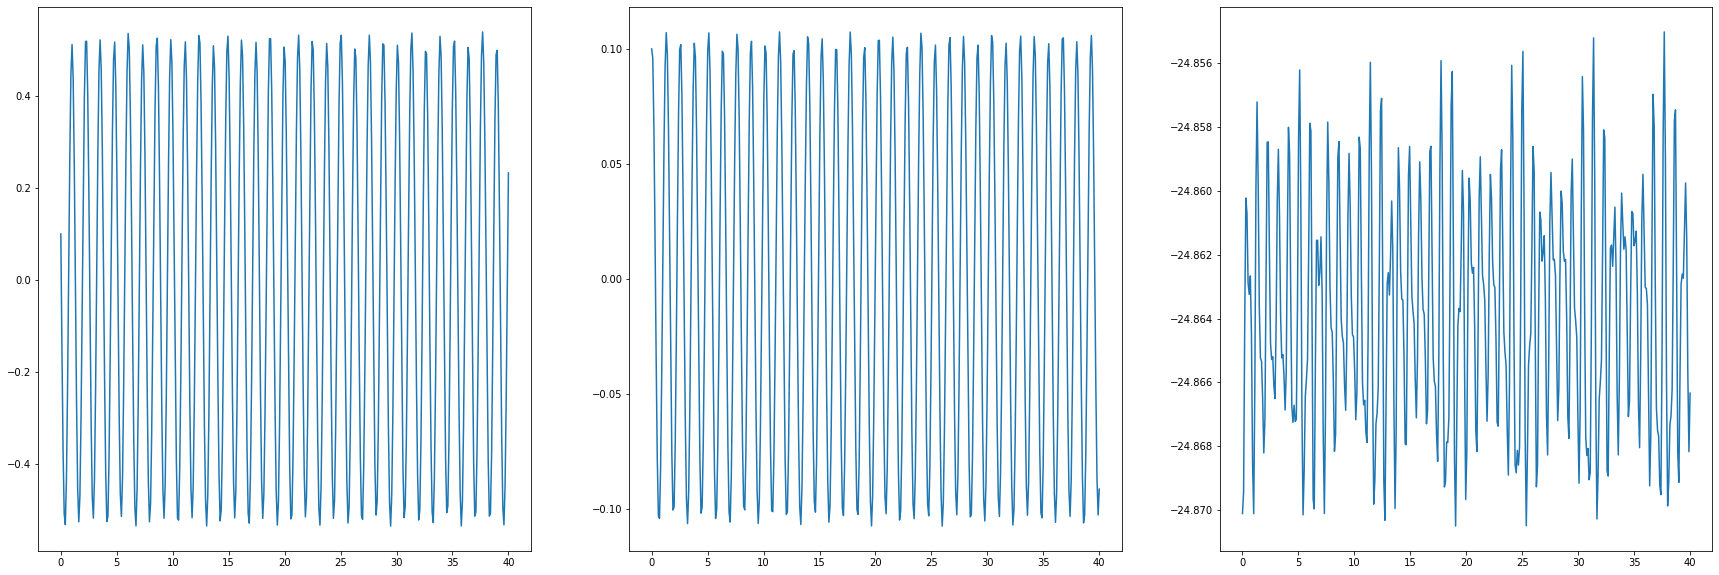

In [6]:
_, axes = plt.subplots(1, 3, figsize=(30, 10))

axes[0].plot(t, pq[:, 0])
axes[1].plot(t, pq[:, 1])
axes[2].plot(t, H(pq[:, 0], pq[:, 1], t))

In [19]:
X_true = np.concatenate((t[:, np.newaxis], pq, H(pq[:, 0], pq[:, 1], t)[:, np.newaxis]), axis=1)
n, p = X_true.shape
M = np.full((n, p), fill_value=True).astype(bool)
M[:, p - 1] = False
M[200:, 1:3] = False


X = np.zeros_like(X_true)
X[M] = X_true[M]


TypeError: 'numpy.ndarray' object is not callable

In [34]:
from cgc.graph import ComputationalGraph, derivative

graph = ComputationalGraph(observables_order=["t", "p", "q", "H"])

graph.add_observable("t")
graph.add_unknown_fn("t", "p", alpha=0.01)
graph.add_unknown_fn("t", "q", alpha=0.01)
graph.add_known_fn("p", "p_dot", derivative)
graph.add_known_fn("q", "q_dot", derivative)
graph.add_aggregator(["p", "q", "t"], "pqt")
graph.add_unknown_fn("pqt", "H", alpha=0.01)
graph.add_known_fn("H", "grad_H", derivative)

graph.add_aggregator(["grad_H", "p_dot"], "(grad_H, p_dot)")
graph.add_aggregator(["grad_H", "q_dot"], "(grad_H, q_dot)")

def q_dot_constraint(grad_H_q_dot):
    grad_H, q_dot = grad_H_q_dot[:, :3], grad_H_q_dot[:, 3]
    Dp_H = grad_H[:, 0]
    return q_dot - Dp_H

def p_dot_constraint(grad_H_p_dot):
    grad_H, p_dot = grad_H_p_dot[:, :3], grad_H_p_dot[:, 3]
    Dq_H = grad_H[:, 1]
    return p_dot + Dq_H

graph.add_constraint("(grad_H, p_dot)", "W1", p_dot_constraint)
graph.add_constraint("(grad_H, q_dot)", "W2", q_dot_constraint)

In [37]:
graph.set_loss_multipliers(constraints_loss_multiplier=1000, data_compliance_loss_multiplier=1000, unknown_functions_loss_multiplier=10)
Z = graph.complete(X, M)

Loss: 23763.9141:   1%|          | 6036/500000 [03:27<4:42:23, 29.15it/s]  

Stopped after 1000 steps with no improvment in Loss


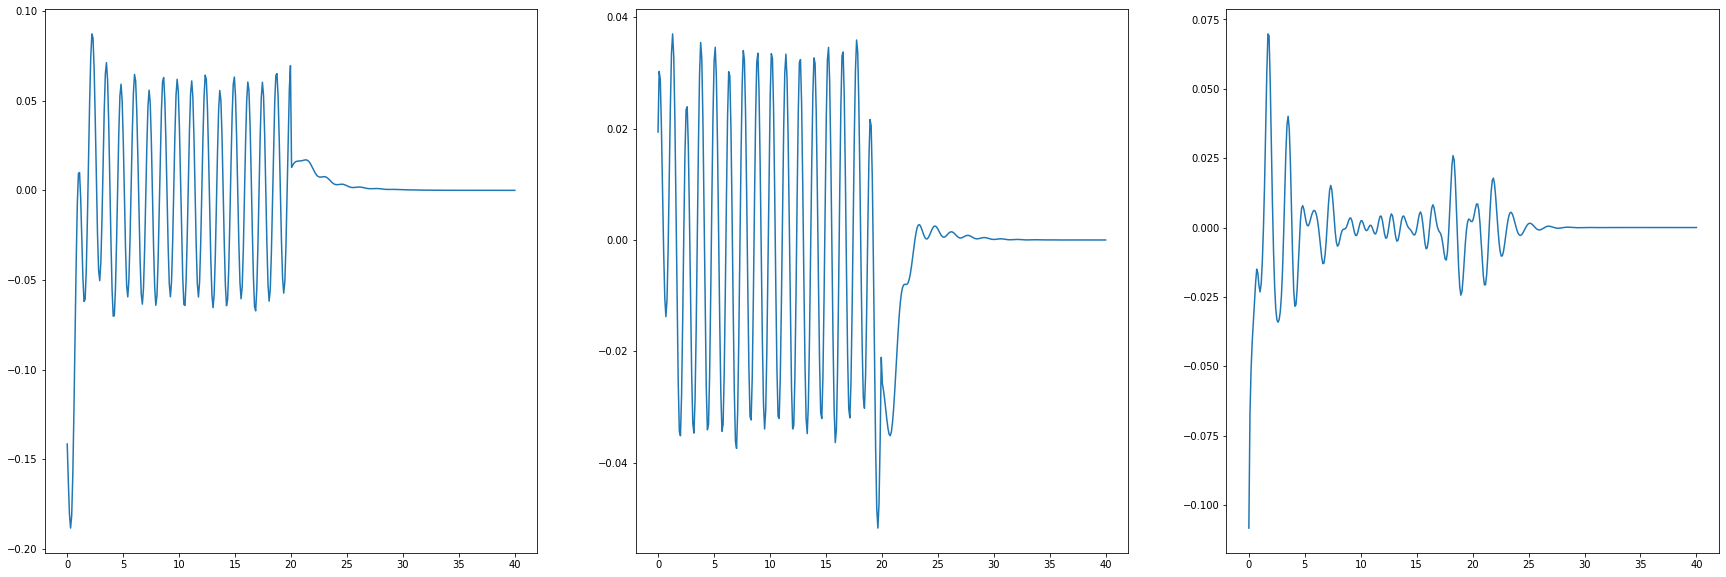

In [38]:
_, axes = plt.subplots(1, 3, figsize=(30, 10))

axes[0].plot(t, Z[:, 1])
axes[1].plot(t, Z[:, 2])
axes[2].plot(t, Z[:, 3])